In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

In [4]:
file_path = 'data/loan_data.csv'  


try:
    df = pd.read_csv(file_path, sep='\t', engine='python')
    print("Data loaded successfully!")
    
    
    pd.set_option('display.float_format', '{:.1f}'.format)  
    pd.set_option('display.max_columns', None)  
    pd.set_option('display.expand_frame_repr', False)  
    
    print(df.head()) 
except FileNotFoundError:
    print(f"Error: The file at {file_path} was not found.")
except pd.errors.EmptyDataError:
    print("Error: No data found in the CSV file.")
except pd.errors.ParserError:
    print("Error: There was a problem parsing the CSV file.")
except Exception as e:
    print(f"An error occurred: {e}")


Data loaded successfully!
    Loan_ID    Gender Married  ApplicantIncome  LoanAmount Loan_Status
0  LP001002      Male      No             5849         NaN           Y
1  LP001003      Male     Yes             4583       128.0           N
2  LP001005      Male     Yes             3000        66.0           Y
3  LP001006      Male     Yes             2583       120.0           Y
4  LP001008      Male      No             6000       141.0           Y


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Loan_ID          598 non-null    object 
 1      Gender        598 non-null    object 
 2   Married          598 non-null    object 
 3   ApplicantIncome  598 non-null    int64  
 4   LoanAmount       577 non-null    float64
 5   Loan_Status      598 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 28.2+ KB


In [7]:
df.columns

Index(['Loan_ID', '   Gender', 'Married', 'ApplicantIncome', 'LoanAmount',
       'Loan_Status'],
      dtype='object')

In [8]:



def preprocess_data(df):
    """
    Preprocesses the input DataFrame.

    Args:
        df: pandas DataFrame

    Returns:
        pandas DataFrame: Preprocessed DataFrame
    """
    # 1. Handle Missing Values
    # Impute numerical features with the mean
    numerical_features = df.select_dtypes(include=['number']).columns
    imputer = SimpleImputer(strategy='mean')
    df[numerical_features] = imputer.fit_transform(df[numerical_features])

    # Impute categorical features with the most frequent value
    categorical_features = df.select_dtypes(include=['object']).columns
    imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_features] = imputer.fit_transform(df[categorical_features])


    # 2. Feature Engineering
    # Check if 'CoapplicantIncome' column exists before proceeding
    if 'CoapplicantIncome' in df.columns:
        df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
        df['LoanAmount_per_TotalIncome'] = df['LoanAmount'] / df['TotalIncome']
    else:
        print("Column 'CoapplicantIncome' not found in the DataFrame. Skipping TotalIncome & LoanAmount_per_TotalIncome")
        # Handle the missing column, e.g., impute values or skip the feature engineering step.

    # Binning continuous variables
    df['ApplicantIncome_bin'] = pd.cut(df['ApplicantIncome'], bins=[0, 2500, 5000, 7500, 10000, float('inf')],
                                      labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

    # 3. Encoding Categorical Variables
    # Before encoding, check if the columns exist
    categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
    existing_categorical_cols = [col for col in categorical_cols if col in df.columns]

    # Label Encoding for categorical features
    for col in existing_categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])


    # 4. Interaction Terms
    # Ensure 'Credit_History' and 'LoanAmount' columns exist
    if 'Credit_History' in df.columns and 'LoanAmount' in df.columns:
        df['LoanAmount_x_CreditHistory'] = df['LoanAmount'] * df['Credit_History']
    else:
        print("Column 'Credit_History' or 'LoanAmount' not found in the DataFrame for interaction. Skipping interaction term")

    # 5. Feature Scaling (Optional but often recommended)
    # Use StandardScaler for numerical features (except the target variable)
    numerical_features_to_scale = [col for col in numerical_features if col != 'Loan_Status']  # Exclude target
    if numerical_features_to_scale:  # Check if there are numerical features to scale
        scaler = StandardScaler()
        df[numerical_features_to_scale] = scaler.fit_transform(df[numerical_features_to_scale])

    return df

In [9]:
features = df.drop('Loan_Status', axis=1)
target = df['Loan_Status'].values

X_train, X_val,	Y_train, Y_val = train_test_split(features, target,
									test_size=0.2,
									random_state=10)

# As the data was highly imbalanced we will balance
# it by adding repetitive rows of minority class.
ros = RandomOverSampler(sampling_strategy='minority',
						random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)

X_train.shape, X.shape

((478, 5), (668, 5))

In [11]:
# Split features and target
features = df.drop('Loan_Status', axis=1)  # Drop the target column
target = df['Loan_Status'].values  # Get the target values

# Handle categorical variables (if necessary)
# For example, using one-hot encoding for categorical columns
features = pd.get_dummies(features, drop_first=True)

# Train-validation split
X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                                  test_size=0.2,
                                                  random_state=10)

# Normalizing the features for stable and fast training
scaler = StandardScaler()

# Only scale numeric features
X_train_scaled = scaler.fit_transform(X_train)  # Scale the training data
X_val_scaled = scaler.transform(X_val)          # Scale the validation data

# Check the shapes of the resulting sets (optional)
print(f"Scaled Training set shape: {X_train_scaled.shape}, Scaled Validation set shape: {X_val_scaled.shape}")

Scaled Training set shape: (478, 601), Scaled Validation set shape: (120, 601)


In [22]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


# Load the CSV data into a DataFrame
file_path = 'data/loan_data.csv'  # Adjust the path as necessary
df = pd.read_csv(file_path, sep='\t', engine='python')

# Clean up column names
df.columns = df.columns.str.strip()

# Convert target variable from categorical to numerical
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})  # Convert 'Y' to 1 and 'N' to 0

# Split features and target
features = df.drop('Loan_Status', axis=1)  # Drop the target column
target = df['Loan_Status'].values  # Get the target values

# One-hot encoding for categorical variables
features = pd.get_dummies(features, drop_first=True)

# Option 1: Drop rows with missing values from both features and target
features = features.dropna()
target = target[features.index]  # Keep only the target values corresponding to the cleaned features

# Train-validation split
X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                                  test_size=0.2,
                                                  random_state=10)

# Normalizing the features for stable and fast training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Fit the SVC model
model = SVC(kernel='rbf')
model.fit(X_train_scaled, Y_train)  # Use the scaled training data

# Evaluate the model
print('Training Accuracy:', metrics.roc_auc_score(Y_train, model.predict(X_train_scaled)))
print('Validation Accuracy:', metrics.roc_auc_score(Y_val, model.predict(X_val_scaled)))


Training Accuracy: 1.0
Validation Accuracy: 0.5


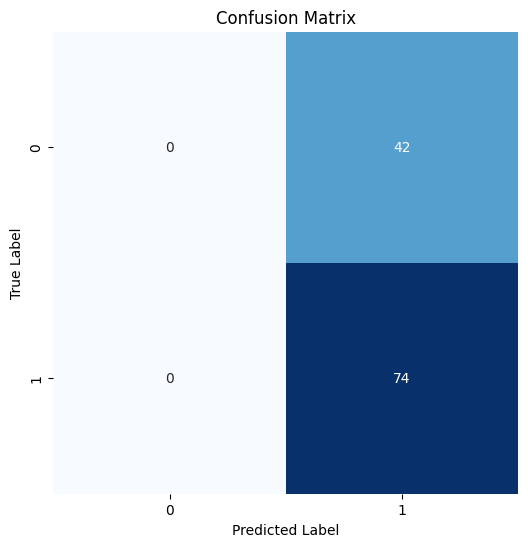

In [25]:
from sklearn.metrics import confusion_matrix

# Assuming you have already made predictions
Y_pred = model.predict(X_val_scaled)

# Compute the confusion matrix
cm = confusion_matrix(Y_val, Y_pred)

plt.figure(figsize=(6, 6))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [26]:
from sklearn.metrics import classification_report
print(classification_report(Y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.64      1.00      0.78        74

    accuracy                           0.64       116
   macro avg       0.32      0.50      0.39       116
weighted avg       0.41      0.64      0.50       116

